In [1]:
# Importing necessary libraries
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from googleapiclient.discovery import build
from googleapiclient.errors import HttpError
from datetime import datetime
import os
from configparser import ConfigParser
import re
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from wordcloud import WordCloud
from langdetect import detect
import langdetect
from textblob import TextBlob
import calendar
import matplotlib.dates as mdates
from matplotlib.dates import DateFormatter
from prettytable import PrettyTable
from tabulate import tabulate
import numpy as np
from collections import defaultdict
import warnings
# from pandas.core.common import SettingWithCopyWarning
from nltk.stem import WordNetLemmatizer
import scipy.stats
from sklearn.preprocessing import RobustScaler, PolynomialFeatures
import statsmodels.api as sm
from statsmodels.formula.api import ols
from statsmodels.stats.outliers_influence import OLSInfluence
import statsmodels.stats.api as sms
from statsmodels.compat import lzip
# Ignore the warning
warnings.filterwarnings('ignore')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tomde\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# A sample code for data preparation has been given below. Feel free to edit when needed

# Load the videos and comments dataframes from their respective CSV files
videos_df = pd.read_csv('videos.csv')
comments_df = pd.read_csv('comments.csv')

# Convert the published_at column to a datetime object for videos_df
videos_df['published_at'] = pd.to_datetime(videos_df['published_at'], format='%Y-%m-%dT%H:%M:%SZ')

# Create a new column that contains the published_at weekly
videos_df['published_at_week'] = videos_df['published_at'].dt.strftime('%Y-%m-%W')

# Create a new column that contains the published_at monthly
videos_df['published_at_month'] = videos_df['published_at'].dt.strftime('%Y-%m')

# Create a new column that contains the published_at monthly
videos_df['published_at_year'] = videos_df['published_at'].dt.strftime('%Y')

# Convert the published_at column to a datetime object for comments_df
comments_df['comment_date'] = pd.to_datetime(comments_df['comment_date'], format='%Y-%m-%dT%H:%M:%SZ')

# Create a new column that contains the published_at weekly
comments_df['comment_date_week'] = comments_df['comment_date'].dt.strftime('%Y-%m-%W')

# Create a new column that contains the published_at monthly
comments_df['comment_date_month'] = comments_df['comment_date'].dt.strftime('%Y-%m')

# Create a new column that contains the published_at monthly
comments_df['comment_date_year'] = comments_df['comment_date'].dt.strftime('%Y')

# Convert the duration column to seconds for videos_df
videos_df['duration'] = videos_df['duration'].apply(lambda x: re.findall(r'PT(\d+)M(\d+)S', x))
videos_df['duration'] = videos_df['duration'].apply(lambda x: int(x[0][0]) * 60 + int(x[0][1]) if len(x) > 0 else 0)

# Prepared DataFrame objects; can be used for data analysis
videos = videos_df
comments = comments_df
videos_comments = pd.merge(videos,comments, on='video_id', how = 'inner') # merged videos and comments

Explain that when the model is categorizing the labels as negative, neutral, positive, I will only take the probability of the positive. The probability closer to 1, meaning that it is positive, closer to 0 meaning its negative. 

## Code for NLP models 

Because I feel like `TextBlob` library gives not very accurate sentiment scores, so I use a pretrained model from `HuggingFace` that is trained from 58 million tweets. The threshold is 0.5, below or above that is negative and positive. I have attached the code to categorize the scores of each `comments` and `video titles` below. For convenience sake, I have exported what the model predicts into a `csv` file.

Link for the model: https://huggingface.co/cardiffnlp/twitter-roberta-base-sentiment

**Confirm that torch is using gpu**

In [3]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

### Explain how the model works
All of this code I got from the HuggingFace page.

In [4]:
from transformers import AutoModelForSequenceClassification
from transformers import AutoTokenizer
from torch.nn.functional import softmax

# PT
MODEL = f"cardiffnlp/twitter-roberta-base-sentiment"
tokenizer = AutoTokenizer.from_pretrained(MODEL)
model = AutoModelForSequenceClassification.from_pretrained(MODEL)

In [5]:
# Sample text
display(videos_comments.comment_text[0])

# Encode the text using tokenizer
encoded_input = tokenizer(videos_comments.comment_text[0], return_tensors='pt', max_length=512, truncation=True)

# Pass the tokenized text through the model to get output scores
output = model(**encoded_input)

# Extract the scores for each sentiment (negative, neutral, positive) from the model output
scores = output[0][0].detach().numpy()

# Apply softmax to convert the scores to probabilities
scores = softmax(torch.tensor(scores)).numpy()

# Create a dictionary for those scores
scores_dict = {
    'negative' : scores[0],
    'neutral' : scores[1],
    'positive' : scores[2]
}

# Probabilities of the sample text in each labels
display(scores_dict)

'permanently messed sense time'

{'negative': 0.817044, 'neutral': 0.16932532, 'positive': 0.013630671}

The model shows the probabilities of 3 labels, negative, neutral and positive, I will only be taking the **positive probability**. This way, I will know that the probability closer to 1, meaning that it is positive, closer to 0 meaning its negative, and the threshold is 0.5, where the text is neutral.

### Apply the code to the `Title` and `Comment` columns
I will be testing out on the first five rows

In [6]:
# Create a test data set
test_data = videos_comments.head()

# Function to get the sentiment score and return the positive probability score
def get_sentiment_scores(text):
    # Encode the text using tokenizer
    encoded_input = tokenizer(text, return_tensors='pt', max_length=512, truncation=True)
    
    # Pass the tokenized text through the model to get output scores
    output = model(**encoded_input)
    
    # Extract the scores for each sentiment (negative, neutral, positive) from the model output
    scores = output[0][0].detach().numpy()
    
    # Apply softmax to convert the scores to probabilities
    scores = softmax(torch.tensor(scores)).numpy()

    return scores[2]

# Function to apply sentiment scoring to a column in a dataframe
def apply_sentiment_score(df, column):
    # Convert the column to string
    df[column] = df[column].astype(str)
    
    scores = []
    for text in df[column]:
        # Apply `get_sentiment_scores` function to get the positive probability score
        score = get_sentiment_scores(text)
        scores.append(score)
    # Create a new column in the DataFrame with the sentiment scores
    df[column + '_sentiment_score'] = scores
    return df


# Output
test_data = apply_sentiment_score(test_data, 'video_title')
test_data = apply_sentiment_score(test_data, 'comment_text')
test_data

,video_id,channel_id,video_title,channel_title,category_name,live_upcoming_none,view_count,like_count,dislike_count,comment_count,...,comment_text,comment_author,comment_date,comment_like_count,parent_comment_id,comment_date_week,comment_date_month,comment_date_year,video_title_sentiment_score,comment_text_sentiment_score
0,d1eEWihvwpQ,UCXIJgqnII2ZOINSWNOGFThA,who declares coronavirus outbreak a pandemic,Fox News,News & Politics,none,456892,3624,0,1940,...,permanently messed sense time,@radioactivebeverage,2024-03-15 01:47:38,1.0,NaN,2024-03-11,2024-03,2024,0.013502,0.013631
1,d1eEWihvwpQ,UCXIJgqnII2ZOINSWNOGFThA,who declares coronavirus outbreak a pandemic,Fox News,News & Politics,none,456892,3624,0,1940,...,covid august super unpleasant got vaccines boo...,@rosieasmrwhispererzephier7021,2022-10-11 02:46:38,0.0,NaN,2022-10-41,2022-10,2022,0.013502,0.010305
2,d1eEWihvwpQ,UCXIJgqnII2ZOINSWNOGFThA,who declares coronavirus outbreak a pandemic,Fox News,News & Politics,none,456892,3624,0,1940,...,showlinemuch better also influenza december la...,@rosieasmrwhispererzephier7021,2023-11-11 02:21:41,0.0,UgxbTG_0cWGvMAee0sx4AaABAg,2023-11-45,2023-11,2023,0.013502,0.718836
3,d1eEWihvwpQ,UCXIJgqnII2ZOINSWNOGFThA,who declares coronavirus outbreak a pandemic,Fox News,News & Politics,none,456892,3624,0,1940,...,happened march videos made,@danhobson24,2022-06-08 21:53:44,0.0,NaN,2022-06-23,2022-06,2022,0.013502,0.051869
4,d1eEWihvwpQ,UCXIJgqnII2ZOINSWNOGFThA,who declares coronavirus outbreak a pandemic,Fox News,News & Politics,none,456892,3624,0,1940,...,year,@monsehere8090,2021-03-14 15:29:55,2.0,NaN,2021-03-10,2021-03,2021,0.013502,0.236997


### Apply the `apply_sentiment_score` to the actual data

In [7]:
# df2 = videos_comments.copy()
# df2 = apply_sentiment_score(df2, 'video_title')
# df2 = apply_sentiment_score(df2, 'comment_text')
# df2.to_csv('df2.csv', index=False)

## Task 2
##### E.2. Use regression analysis with visualization to test the following hypothesises:

* H1: There is a meaningful relationship between the sentiment of a video title and the sentiments of its corresponding comments.  
* H2: There is a meaningful relationship between the video likes and the sentiments of its corresponding comments.
* H3: There is a meaningful relationship between the duration of a video and the sentiments of its corresponding comments.

# Analysis
Before going into any analysis, I want to compare the different between `correlation` and `regression`. Correlation hints a relationship between two variables via the strength and direction. We can see if there's a statistical association by examining the correlation coefficient. Regression looks at independent variable(s) and dependent variable. It predicts whether a change in the predictors will affect the response variable

,video_title,video_title_sentiment_score,comment_sentiment_score
375,state department warns us citizens not to trav...,0.006,0.084000
32,brace yourself doctors in italy share coronavi...,0.099,0.165634


(464, 3)

,video_title,like_count,comment_sentiment_score
459,working in coronavirus why one dominos finally...,684.0,0.140714
245,how can you treat symptoms of coronavirus and ...,1659.0,0.080700


(464, 3)

,video_title,duration,comment_sentiment_score
34,brianna keilar breaks down on live tv over cor...,323.0,0.203571
163,coronavirus who leaders answer questions on co...,0.0,0.094500


(464, 3)

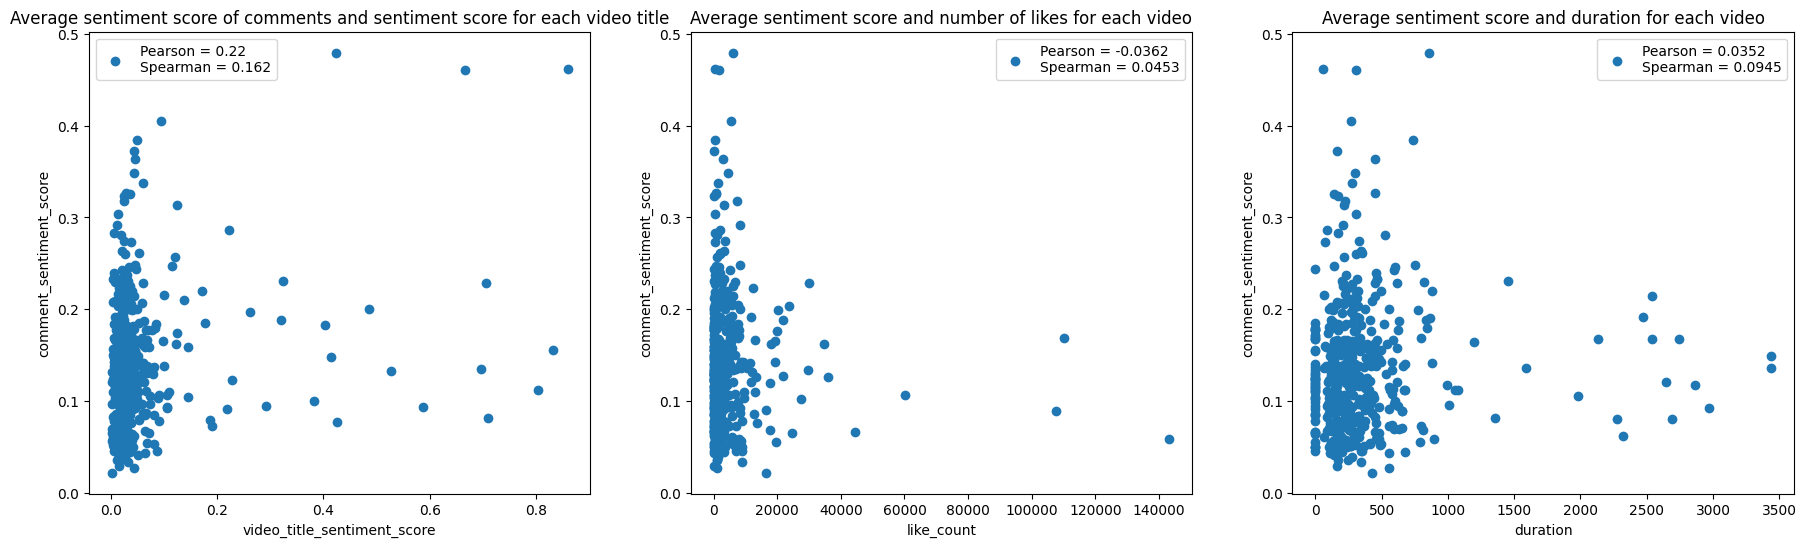

In [8]:
# load the data
df2 = pd.read_csv('df2.csv')
df3 = df2.copy()


# create subplots for each plot
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(22,6))
def plot_corr(x, y, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    r = scipy.stats.pearsonr(x, y)[0]
    ρ = scipy.stats.spearmanr(x, y)[0]
    ax.scatter(x, y, label=f"Pearson = {r:.3}\nSpearman = {ρ:.3}")
    ax.legend()
    if title:
        ax.set_title(title)
        ax.set_xlabel(x.name)
        ax.set_ylabel(y.name)

# Round the data
df2['video_title_sentiment_score'] = df2['video_title_sentiment_score'].round(3)
df2.rename({'comment_text_sentiment_score':'comment_sentiment_score'}, axis=1, inplace=True)
df2['comment_sentiment_score'] = df2['comment_sentiment_score'].round(3)

# group the comments by video and calculate the average sentiment score of comments and sentiment score for each video title
grouped_data1 = df2.groupby('video_title')[['video_title_sentiment_score', 'comment_sentiment_score']].mean().reset_index()
display(grouped_data1.sample(2), grouped_data1.shape)

# plot the first subplot
plot_corr(grouped_data1['video_title_sentiment_score'], grouped_data1['comment_sentiment_score'], axes[0], 'Average sentiment score of comments and sentiment score for each video title')

# group the comments by video and calculate the average sentiment score and number of likes for each video
grouped_data2 = df2.groupby(['video_title'])[['like_count', 'comment_sentiment_score']].mean().reset_index()
display(grouped_data2.sample(2), grouped_data2.shape)

# plot the second subplot
plot_corr(grouped_data2['like_count'], grouped_data2['comment_sentiment_score'], axes[1], 'Average sentiment score and number of likes for each video')

# group the comments by video and calculate the average sentiment score and duration for each video
grouped_data3 = df2.groupby(['video_title'])[['duration', 'comment_sentiment_score']].mean().reset_index()
display(grouped_data3.sample(2), grouped_data3.shape)

# plot the third subplot
plot_corr(grouped_data3['duration'], grouped_data3['comment_sentiment_score'], axes[2], 'Average sentiment score and duration for each video')

Notes before explaining the observations. 

I use scatterplots to look at the relationship between two variables. There are 2 types of correlations I used, which are Pearson and Spearman. Pearson assumes we have a normally distribution and have continous variables. Spearman measures a monotonic relationship (meaning if one increases, the other increases as well) and does not assume we have a normal distribution.

**Observation**

From the plots, we can see that `video_title_sentiment_score` and `duration` show some correlation. The `like_count` doesn't seem to be correlated. From the correlation analysis, we can conclude that `video_title_sentiment_score` have a positive statistical association with the `comment_sentiment_score` and the `duration` have negative one.

Also, we can see that most of the `video_title_sentiment_score` and `comment_sentiment_score` have low positive probabilities. This means most of the sentiment are negative.

## Performing regression analysis
**I will first merge the three grouped data dataframe via `video_title`**

In [9]:
display(grouped_data1.shape, grouped_data2.shape, grouped_data3.shape)
# first merge
merge_df = pd.merge(grouped_data1, grouped_data2, on='video_title')

merge_df.drop(['comment_sentiment_score_y'], axis=1, inplace=True)
merge_df.rename({'comment_sentiment_score_x':'comment_sentiment_score'}, axis=1, inplace=True)

# second merge
merge_df = pd.merge(merge_df, grouped_data3, on='video_title')
merge_df.drop(['comment_sentiment_score_y'], axis=1, inplace=True)
merge_df.rename({'comment_sentiment_score_x':'comment_sentiment_score'}, axis=1, inplace=True)
display(merge_df.head(3), merge_df.shape)

(464, 3)

(464, 3)

(464, 3)

,video_title,video_title_sentiment_score,comment_sentiment_score,like_count,duration
0,states report rise in new coronavirus cases,0.032,0.101609,680.0,119.0
1,states see an increase in coronavirus cases,0.032,0.033350,8897.0,344.0
2,states set daily record for coronavirus cases...,0.054,0.127600,2435.0,0.0


(464, 5)

In [10]:
merge_df.isna().sum()

video_title                    0
video_title_sentiment_score    0
comment_sentiment_score        0
like_count                     0
duration                       0
dtype: int64

### Things to look for before doing regression analysis
**Summary output**

1. `R-squared`: Measures the amount of variability in a dependent variable can be explained in the independent variable in the range of 0 to 1(1 is the best). In other words, it tells us if the y can be predicted by the x.
2. `Prob (F-statistics)`: p-value of F-statistics. It test the significance for the entire regression. At α = 0.05, this regression is statistically significant when p-value < 0.05. If p-value < 0.05 means we can reject the null hypothesis and conclude that the overall regression model is statistically significant. In other words, there is strong evidence suggesting that independent variables have significant effect on the dependent variable.
3. `P>|t|`: p-value of the coefficient's t-test. Similar to the one above, if p-value < 0.05, we reject the null hypothesis which is coefficient is equal to 0 or in other words, the predictor variable has a significant effect on the dependent variable.
4. `Prob(Omnibus) and Prob(JB)`: checks if the residuals are normally distributed. It tests the p-value with the null hypothesis which is the residuals are normally distributed.

**Check if model violates 3 assumptions**

1. `Multicollinearity`
   - Two or more independent variables are highly correlated => makes it hard to distinguish the individual effects of the predictors on the dependent variable
2. `Non-Normality of Residuals`
   - In regression analysis, we assume all residuals are normally distributed. Any deviations from this can effect the reliability of our hypothesis tests.
3. `Heteroskedasticity`
   - The variance of the residuals is not constant across all levels of independent variables.
   - We want `homoscedasticity`, the opposite of `Heteroskedasticity`

**Regression analysis**

Since, we are working with only 3 predictors in part 1, I will be ignoring `Multicollinearity`.

In [11]:
# Scale the data
scaler = RobustScaler()

merge_df_scaled = merge_df.drop(['video_title'], axis=1)
merge_df_scaled = scaler.fit_transform(merge_df_scaled) 
merge_df_scaled = pd.DataFrame(merge_df_scaled, columns=merge_df.drop(['video_title'], axis=1).columns)

# Fit the model
model = ols("comment_sentiment_score ~ video_title_sentiment_score + like_count + duration", data=merge_df_scaled).fit()
print(model.summary())

                               OLS Regression Results                              
Dep. Variable:     comment_sentiment_score   R-squared:                       0.050
Model:                                 OLS   Adj. R-squared:                  0.043
Method:                      Least Squares   F-statistic:                     8.007
Date:                     Thu, 16 May 2024   Prob (F-statistic):           3.27e-05
Time:                             09:42:36   Log-Likelihood:                -592.73
No. Observations:                      464   AIC:                             1193.
Df Residuals:                          460   BIC:                             1210.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------

**Explain**
- `R-squared`: The result shows about 5% of the total variation in the `comment_text_sentiment_score` is explained by regression model.
- `Prob (F-statistic)`: smaller than 0.05. This indicates that there is strong evidence that independent variables have significant effect on the dependent variable.
- `P>|t|`:
  - Only `video_title_sentiment_score` p-value rejects the null hypothesis which is the predictor variable has no effect on the dependent variable. The other independent variables accept the null hypothesis.
- `Prob(Omnibus) and Prob(JB)`: p-value < 0.05, this rejects the null hypothesis which of the residuals are normally distributed.

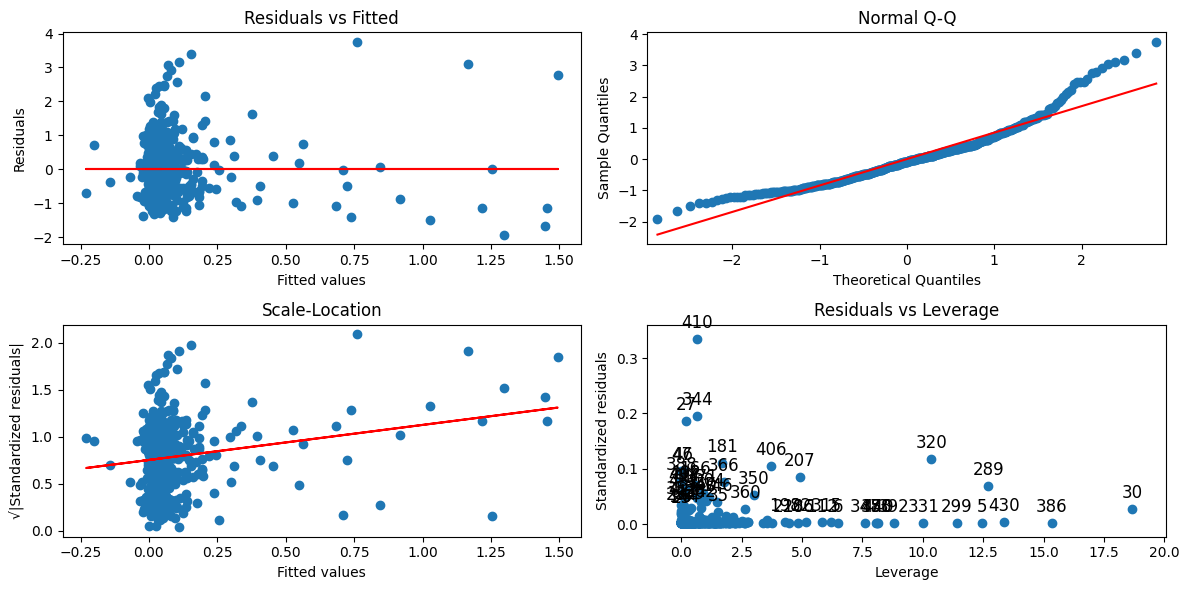

In [12]:
def diagnostic_plots(model):
    residuals = model.resid

    # Residuals vs Fitted Plot
    plt.figure(figsize=(12, 6))
    plt.subplot(2, 2, 1)
    plt.scatter(model.fittedvalues, residuals)
    plt.xlabel('Fitted values')
    plt.ylabel('Residuals')
    plt.title('Residuals vs Fitted')
    # Calculate the linear regression line
    fit = np.polyfit(model.fittedvalues, residuals, deg=1)
    plt.plot(model.fittedvalues, fit[0] * model.fittedvalues + fit[1], color='red')

    # Normal QQ Plot
    plt.subplot(2, 2, 2)
    sm.qqplot(residuals, line='r', ax=plt.gca())
    plt.title('Normal Q-Q')

    # Scale-Location Plot (Square root of standardized residuals vs. fitted values)
    plt.subplot(2, 2, 3)
    sqrt_standardized_resid = np.sqrt(np.abs(OLSInfluence(model).resid_studentized))
    plt.scatter(model.fittedvalues, sqrt_standardized_resid)
    plt.xlabel('Fitted values')
    plt.ylabel('√|Standardized residuals|')
    plt.title('Scale-Location')
    # Calculate the linear regression line
    fit = np.polyfit(model.fittedvalues, sqrt_standardized_resid, deg=1)
    plt.plot(model.fittedvalues, fit[0] * model.fittedvalues + fit[1], color='red')

    # Residuals vs Leverage Plot
    plt.subplot(2, 2, 4)
    sm.graphics.plot_leverage_resid2(model, ax=plt.gca())
    plt.xlabel('Leverage')
    plt.ylabel('Standardized residuals')
    plt.title('Residuals vs Leverage')

    plt.tight_layout()
    plt.show()

diagnostic_plots(model)

1. `Residuals vs Fitted`: there might be a pattern in the residuals and fitted values as most of the points are clustered on the left side
3. `Normal Q-Q`: it seems like there are some values influencing the distribution, causing the residual to be not a normal distribution

**Using Cook’s Distance to remove outliers**
- Source: https://towardsdatascience.com/identifying-outliers-in-linear-regression-cooks-distance-9e212e9136a
- Cook’s Distance is a summary of how much a regression model changes when <i>i</i>th observation is removed. It also take into account of the leverage and residual of each observation

In [13]:
# Calculate Cook's distance
cooks_d = OLSInfluence(model).cooks_distance[0]

# Calculate the threshold for identifying influential points
threshold = 3 * np.mean(cooks_d)

# Find influential points
influential_indices = np.where(cooks_d > threshold)[0]
influential = merge_df_scaled.index[influential_indices]

print(influential)

Index([ 27,  30,  57, 146, 166, 181, 204, 207, 289, 320, 344, 350, 360, 366,
       371, 406, 410, 430],
      dtype='int64')


In [14]:
# Remove the outlier
df2 = merge_df_scaled.drop(influential) 

# Fit the model again with the cleaned dataset
x2 = df2.drop(['comment_sentiment_score'], axis=1)
x2 = scaler.fit_transform(x2)
x2 = sm.add_constant(x2)
y2 = df2['comment_sentiment_score']

model2 = sm.OLS(y2, x2).fit()
print(model2.summary())

                               OLS Regression Results                              
Dep. Variable:     comment_sentiment_score   R-squared:                       0.026
Model:                                 OLS   Adj. R-squared:                  0.020
Method:                      Least Squares   F-statistic:                     3.967
Date:                     Thu, 16 May 2024   Prob (F-statistic):            0.00827
Time:                             09:42:37   Log-Likelihood:                -536.26
No. Observations:                      446   AIC:                             1081.
Df Residuals:                          442   BIC:                             1097.
Df Model:                                3                                         
Covariance Type:                 nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
co

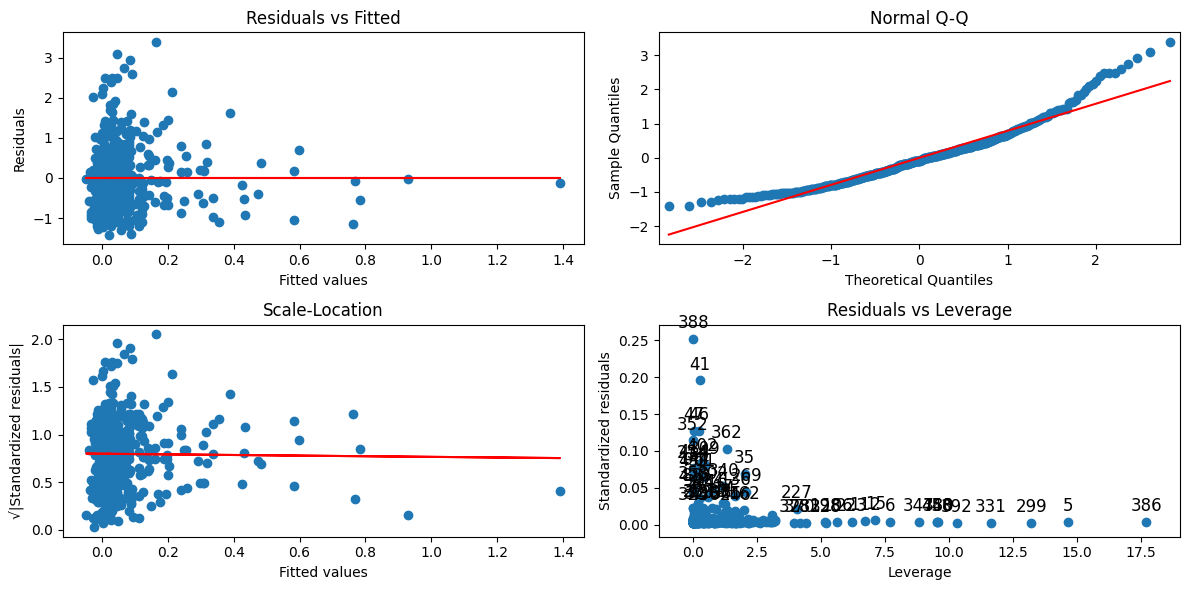

In [15]:
diagnostic_plots(model2)

I want to further check on the constant of variance or `homoskedasticity`. I will be using these two tests below. The null hypothesis is the variance of the residuals is constant across all levels of independent variables.

In [16]:
# Breush-Pagan test
name = ["Lagrange multiplier statistic", "p-value", "f-value", "f p-value"]
test = sms.het_breuschpagan(model2.resid, model2.model.exog)
lzip(name, test)

# Goldfeld-Quandt test
name = ["F statistic", "p-value"]
test = sms.het_goldfeldquandt(model2.resid, model2.model.exog)
lzip(name, test)

[('F statistic', 1.225234466984658), ('p-value', 0.06680198589848632)]

After removing the outliers we can see that
- Still only `video_title_sentiment_score` have have a significant effect on `comment_sentiment_score`
- The `residual vs fitted` graph shows there might be a pattern, but the two tests show that the p-value is > 0.05, meaning that we can not reject `H0`. Then, we can say that our model is **homoskedasticity** and only the assumption of the residuals are **normally distributed is violated**.
- **Possible reason for the assumption violation**: the majority amount of negative sentiments in comments may be main culprit for the skewness in our distribution.

**Examining individual effects of the significant predictors**

To examine the effect in individual predictors on the response variable, we can use `partial regression plot`. This plot isolate the effect of other predictors and only compare 1 predictor with the response variable.

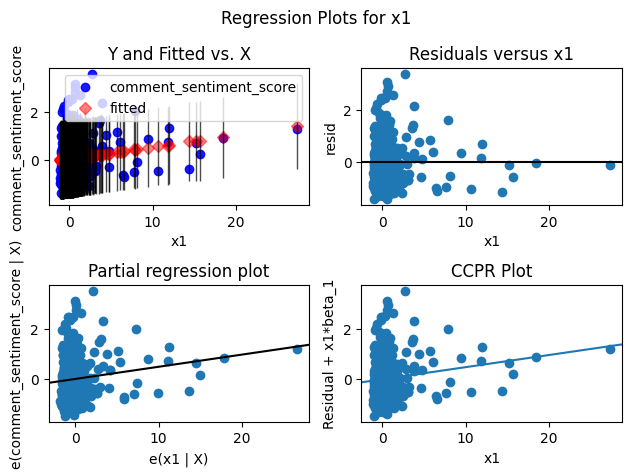

In [19]:
fig = sm.graphics.plot_regress_exog(model2, "x1")
fig.tight_layout(pad=1.0)

`x1` is the `video_title_sentiment_score` and there seems to be a positive relationship with the `comment_sentiment_score`.

## Conclusion
In conclusion, only `video_title_sentiment_score` has a significant and positive relationship with the `comment_sentiment_score`.

Here are some of my assumptions after the conclusion. The positive relationship between video title sentiment and comment sentiment may indicate that the tone set by the title greatly affects the comments. What I mean by this is during the time of uncertainties, people tend to find positive things to uplift their mood. Also, during the COVID19 period, the majority of us is are a state of worry because I do not know much about this new virus and pandemic. For that reason, the `video_title_sentiment_score` and `comment_sentiment_score` are skewed toward the negative side.